# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [40]:
root = "/data/gpfs/home/tfaske/g/rabbruh"

In [41]:
cd $root

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh


In [42]:
pwd

'/data/gpfs/assoc/parchmanlab/tfaske/rabbruh'

# Sample random fastq for optimizer

    rabbruh 400 individuals from one site. Make fastq.size file and pick the largest 40 files
    
    in terminal:
    ls -l fastq/EN_TF_* > fastq_size.txt
 

In [59]:
#fq_size = pd.read_csv('fastq_size.txt',usecols=[5,9],sep=' ',names=['size','fq'])
fq_size = pd.read_csv('fastq_size.txt',sep='\s+',usecols=[4,8],names=['size','fq'])
fq_size.loc[:10,]

,size,fq
0,67548672,fastq/EN_TF_100.F.fq.gz
1,110280990,fastq/EN_TF_101.F.fq.gz
2,122571303,fastq/EN_TF_102.F.fq.gz
3,111357485,fastq/EN_TF_103.F.fq.gz
4,94973260,fastq/EN_TF_104.F.fq.gz
5,59785693,fastq/EN_TF_105.F.fq.gz
6,89894113,fastq/EN_TF_106.F.fq.gz
7,61289898,fastq/EN_TF_107.F.fq.gz
8,115595655,fastq/EN_TF_108.F.fq.gz
9,98913561,fastq/EN_TF_109.F.fq.gz


In [63]:
fq_size.sort_values('size',axis=0,ascending=False,inplace=True)
fq_size.loc[:10,]

,size,fq
374,208620256,fastq/EN_TF_77.F.fq.gz
177,161955392,fastq/EN_TF_260.F.fq.gz
377,146444569,fastq/EN_TF_7.F.fq.gz
10,146005138,fastq/EN_TF_10.F.fq.gz


In [64]:
fq_top40 = fq_size.fq[:40]
len(fq_top40)

40

In [65]:
!mkdir refOpt

In [70]:
def write_cp_refOpt_sh(fq_files):
    with open("cp_refOpt.sh", "w") as o:
        o.write("""#!/bin/bash \n""")
        for fq in fq_files:
            o.write("""cp {} refOpt &\n""".format(fq))

In [71]:
write_cp_refOpt_sh(fq_top40)

# run cp_ref.sh
    cd /data/gpfs/home/tfaske/g/rabbruh
    bash cp_ref.sh

# make a slurm script to run ReferenceOpt.sh 

**Scripts are available in other_scripts/refOpt**  

ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors

In [72]:
refOpt = '/data/gpfs/home/tfaske/g/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = '/data/gpfs/home/tfaske/g/rabbruh/refOpt'

In [73]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh/refOpt


In [80]:
### select options
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
Cpus = 32
email = 'tfaske@nevada.unr.edu'

In [81]:
def write_refOpt_sh(refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus,email):
    with open("run_refOpt.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=cpu-s1-bionres-0
#SBATCH --partition=cpu-s1-bionres-0
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=2500
#SBATCH --job-name refOpt
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (Cpus,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("""%s %d %d %d %d %s %d"""% (refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus))

In [82]:
write_refOpt_sh(refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus,email)

# run refOpt.sh in slurm
    cd /data/gpfs/home/tfaske/g/balsam/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt

In [83]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh/refOpt


R[write to console]: Parsed with column specification:
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)



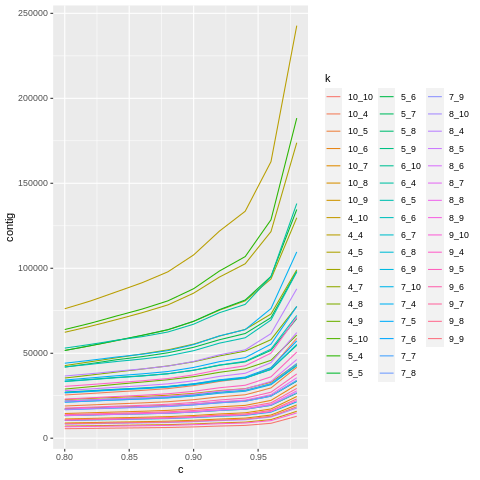

In [84]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .94 is the winner!

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 94 add +-2 (e.g. 92,96)

In [85]:
cd $root

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh


In [86]:
sim_val = [92,94,96]

In [87]:
src_dir = '/data/gpfs/home/tfaske/g/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [88]:
len(mapOpt_sh), mapOpt_sh

(3,
 ['/data/gpfs/home/tfaske/g/src/refOpt/./Map92.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map94.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map96.sh'])

In [98]:
#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
### select options
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
Cpus = 16
email = 'tfaske@nevada.unr.edu'

In [99]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh/refOpt


In [100]:
def write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("run_mapOpt%d.sh" % (sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=cpu-s1-bionres-0
#SBATCH --partition=cpu-s1-bionres-0
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=2500
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (Cpus,sim,sim,email))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,Cpus))

In [101]:
write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email)

In [102]:
mapShells = !find $refOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/home/tfaske/g/rabbruh/refOpt/run_mapOpt92.sh',
 '/data/gpfs/home/tfaske/g/rabbruh/refOpt/run_mapOpt96.sh',
 '/data/gpfs/home/tfaske/g/rabbruh/refOpt/run_mapOpt94.sh']

In [103]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [104]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh
    cd /data/gpfs/home/tfaske/g/rabbruh/refOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [106]:
cd $root

/data/gpfs/assoc/parchmanlab/tfaske/rabbruh


In [108]:
mapResults = !find . -name 'mapping*results'
mapResults

['./mapOpt94/mapping94.results',
 './mapOpt96/mapping96.results',
 './mapOpt92/mapping92.results']

In [109]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

./mapOpt94/mapping94.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
22.8121	30.0835	133555	101218	4	4	60933871	0	3.04669e+06	0	0
29.1728	36.378	102658	82269.2	4	5	59896915	0	2.99485e+06	0	0
36.3653	43.7766	80827	67097.7	4	6	58786734	0	2.93934e+06	0	0
44.9355	52.5267	64001	54717.7	4	7	57519180	0	2875959	0	0
54.543	62.8934	51264	44432.7	4	8	55922903	0	2.79615e+06	0	0
66.6825	76.1957	40832	35716.5	4	9	54456919	0	2.72285e+06	0	0
91.0347	93.0847	29158	28505	4	10	53089600	0	2654480	0	0
28.1312	35.4425	106870	84775.9	5	4	60128063	0	3.0064e+06	0	0
36.163	43.5413	81319	67498.1	5	5	58815409	0	2.94077e+06	0	0
46.3819	53.0943	61609	53790.8	5	6	57151842	0	2.85759e+06	0	0
62.0845	64.8278	44937	43014.3	5	7	55799028	0	2.78995e+06	0	0
76.4981	78.9213	35536	34430	5	8	54370225	0	2.71851e+06	0	0
94.1068	96.3101	28139	27486.5	5	9	52963310	0	2.64817e+06	0	0
116.285	118.364	22102	21708.4	5	10	51404743	0	2.57024e+06	0	0
37.3761	41.8145	78751	70

In [122]:
%%R 
library(readr)
setwd('/data/gpfs/assoc/parchmanlab/tfaske/rabbruh')

mapping92 <- read_table2('mapOpt92/mapping92.results')
mapping92$k <- paste0(mapping92$K1,'_',mapping92$K2)
mapping92$sim <- '92'
mapping92$ratio <- scale(mapping92$SUM_1) / (scale(mapping92$MeanContigsMapped) / scale(mapping92$Cov) )


mapping94 <- read_table2('mapOpt94/mapping94.results')
mapping94$k <- paste0(mapping94$K1,'_',mapping94$K2)
mapping94$sim <- '94'
mapping94$ratio <- scale(mapping94$SUM_1) / (scale(mapping94$MeanContigsMapped) / scale(mapping94$Cov) )

mapping96 <- read_table2('mapOpt96/mapping96.results')
mapping96$k <- paste0(mapping96$K1,'_',mapping96$K2)
mapping96$sim <- '96'
mapping96$ratio <- scale(mapping96$SUM_1) / (scale(mapping96$MeanContigsMapped) / scale(mapping96$Cov) )

#print(mapping92)
#print(mapping94)
#print(mapping96)

#map_df
map_df <- rbindlist(list(mapping92,mapping94,mapping96))
head(map_df)

R[write to console]: Parsed with column specification:
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)

R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  2  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  3  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  4  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  5  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
... ... .......... .......... ............................
See problems(...) for more details.


R[write to console

       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1: 25.5227 32.7152  123587           96425.1  4  4 63085944      0 3154300
2: 32.2458 39.2555   96075           78919.4  4  5 61961002      0 3098050
3: 39.8615 47.0451   76324           64667.3  4  6 60848648      0 3042430
4: 48.8748 56.1372   60899           53018.7  4  7 59529454      0 2976470
5: 58.7787 66.6786   49127           43305.7  4  8 57753559      0 2887680
6: 78.2132 80.1894   35935           35049.6  4  9 56213370      0 2810670
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim      ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  92 -0.8444856
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  92 -0.9337206
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  92 -1.0406460
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  92 -1.1379189
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  92 -1.1922613
6:        0    0     <NA>   <NA

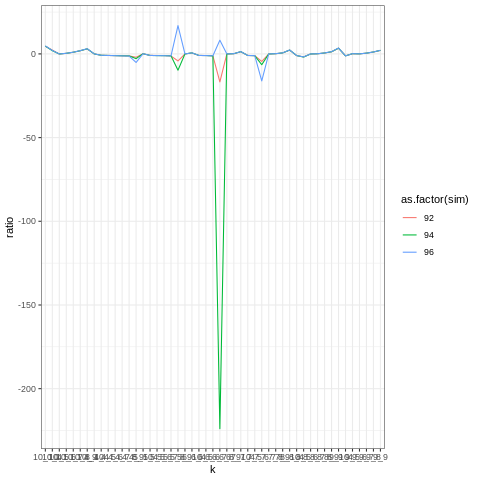

In [123]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [124]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     1.033130e+02      1.068211e+02      3.936802e+04      3.555571e+04 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      5.292932e+07      2.646466e+06 


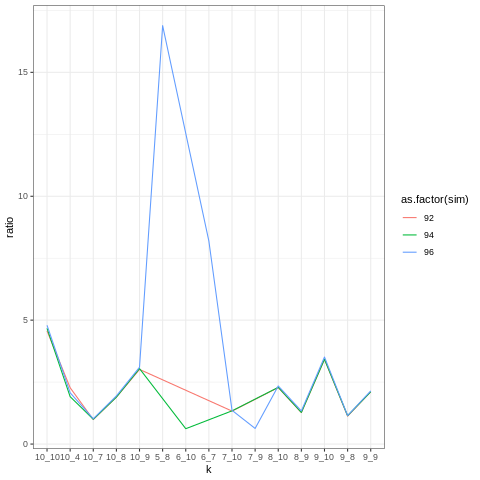

In [125]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

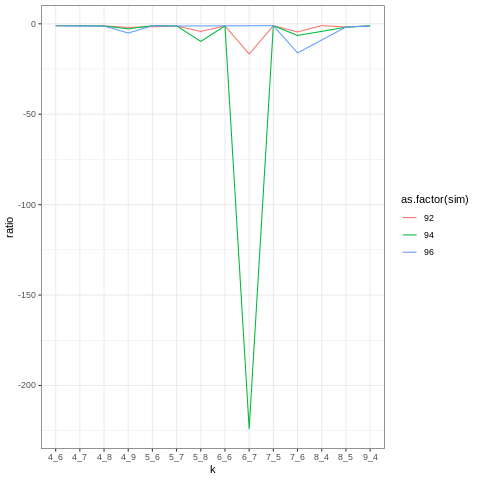

In [126]:
%%R
map_bot <- map_df[which(map_df$ratio < quantile(map_df$ratio,probs=.25)),]

#SUM Properly
ggplot(data=map_bot,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [127]:
%%R
map_df[which(map_df$k %in% c('6_7','5_8','6_10')),c(1:7,9,17)]

        Cov  Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
1:  80.5831  82.7503   34720           33811.7  5  8 55958493 2797920  92
2:  81.8473  84.3140   34288           33286.7  6  7 56129211 2806460  92
3: 154.2650 155.8910   16674           16502.3  6 10 51447372 2572370  92
4:  76.4981  78.9213   35536           34430.0  5  8 54370225 2718510  94
5:  76.8665  79.5670   35322           34110.8  6  7 54303080 2715154  94
6: 146.3270 148.5020   17042           16790.8  6 10 49876984 2493850  94
7:  64.2776  66.4176   40566           39261.7  5  8 52150973 2607550  96
8:  64.5119  66.9894   40489           38996.1  6  7 52241743 2612090  96
9: 124.7110 126.4630   19335           19069.1  6 10 48228422 2411420  96


# Map results 
    sim=92 K1=6 k2=7 WINNER
    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir